In [1]:
# Data Processing
import os
import sys
import pandas as pd
import warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
from sklearn.metrics import brier_score_loss, roc_curve, roc_auc_score, auc

import matplotlib.pyplot as plt
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from scipy.stats import randint, uniform

In [2]:
def metrics_function(confusion_matrix):
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[1][0]
    FN = confusion_matrix[0][1]
    TN = confusion_matrix[1][1]
    TPR = TP / (TP + FN) # Recall
    TNR = TN / (TN + FP)
    FPR = FP / (TN + FP)
    FNR = FN / (TP + FN)
    NPV = TN / (TN + FN)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    ACCURACY = (TP + TN) / (TP + FP + FN + TN)
    PRECISION = TP / (TP + FP)
    ERROR_RATE = (FP + FN) / (TP + FP + FN + TN)
    F1 = (2 * TP) / (2 * TP + FP + FN)
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    return [TP, TN, FP, FN, TPR, TNR, FPR, FNR, PRECISION, F1, ACCURACY, ERROR_RATE, BACC, TSS, HSS]


In [3]:
# Get data features and labels
# Split the data into features (X) and target (y)

sentiment_data = pd.read_csv(f'{os.getcwd()}/dataset/review_sentiment_labelled.csv')
X = sentiment_data["Sentence"]
y = sentiment_data['Score']
train_sentiment, test_sentiment, train_score, test_score = train_test_split(X, y, test_size=0.3)

vectorizer = CountVectorizer()

vector_sentiment_train = vectorizer.fit_transform(train_sentiment)
vector_sentiment_test = vectorizer.transform(test_sentiment)


Best hyperparameters: {'max_depth': 16, 'n_estimators': 238}


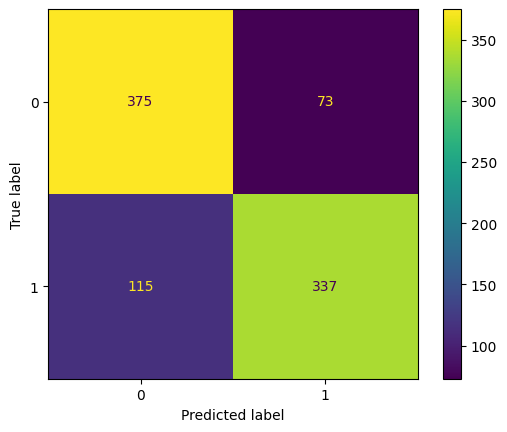

In [6]:
#Random Forrest Implementation
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=10)

# Fit the random search object to the data
rand_search.fit(vector_sentiment_train, train_score)
# # Create a variable for the best model
best_rf = rand_search.best_estimator_

# # Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

#Confusion Matrix setup, prediction with the best models
predicted_score_best = best_rf.predict(vector_sentiment_test)
cm = confusion_matrix(test_score, predicted_score_best)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


Best Hyperparameters:  {'C': 1.8882755431897569, 'gamma': 2.023589647725158, 'kernel': 'linear'}


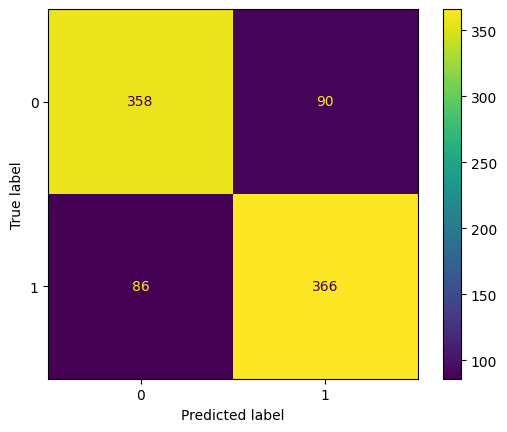

In [7]:
# Support Vector Machine Implementation
svm = SVC()
param_dist = {
    'C': uniform(0.1, 10),  # Uniform distribution between 0.1 and 10
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 50))
}
randomized_search = RandomizedSearchCV(estimator=svm, param_distributions=param_dist, n_iter=10, cv=10)

randomized_search.fit(vector_sentiment_train, train_score)

print("Best Hyperparameters: ", randomized_search.best_params_)
best_svm = randomized_search.best_estimator_

predicted_score_best_svm = best_svm.predict(vector_sentiment_test)
cm_svm = confusion_matrix(test_score, predicted_score_best_svm)

ConfusionMatrixDisplay(confusion_matrix=cm_svm).plot();





I0000 00:00:1731690180.624478   27612 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


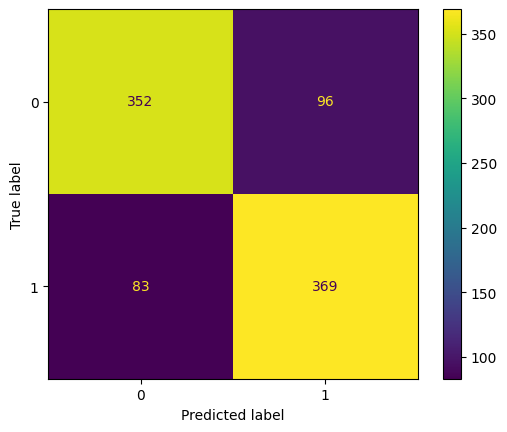

In [8]:
# RNN Bidirectional LSTM Implementation 
VOCAB_SIZE = 3000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(np.array(train_sentiment))
rnn = tf.keras.Sequential([encoder,
                           tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                                     output_dim=64,
        # Use masking to handle the variable sequence lengths
                                                     mask_zero=True),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                           tf.keras.layers.Dense(64, activation='relu'),
                           tf.keras.layers.Dense(1)])

rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
	# fit model
rnn.fit(np.array(train_sentiment), np.array(train_score), epochs=10, batch_size=64, verbose=0)

predicted_score = rnn.predict(test_sentiment, verbose=0)
# print(predicted_score)
predicted_score_class = (tf.sigmoid(predicted_score) > 0.5).numpy().astype("int64")
cm_rnn = confusion_matrix(test_score, predicted_score_class)
ConfusionMatrixDisplay(confusion_matrix=cm_rnn).plot();

In [9]:
rf_evaluate = []
svm_evaluate = []
biLSTM_evaluate = []
metric_des = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision','F1_measure', 'Accuracy', 'Error_rate', 'BACC', 
              'TSS', 'HSS', 'Brier_Score_loss', 'ROC_AUC']
# Implement KFold cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
iter = 0
for tr_index, ts_index in k_fold.split(X):
    iter += 1
    print(f'Iteration {iter}')
    train_sentiment, test_sentiment = X[tr_index], X[ts_index]
    train_score, test_score = y[tr_index], y[ts_index]
    rf_model_iter = RandomForestClassifier(max_depth=best_rf.max_depth, n_estimators=best_rf.n_estimators) # Initialize RF with best params
    svm_model_iter = SVC(C=best_svm.C, gamma=best_svm.gamma, kernel=best_svm.kernel) # Initialize SVM with best params
    VOCAB_SIZE = 3000
    encoder_iter = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
    encoder_iter.adapt(np.array(train_sentiment))
    biLSTM_model_iter = tf.keras.Sequential([encoder_iter, tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                                     output_dim=64,
                                                     mask_zero=True),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                           tf.keras.layers.Dense(64, activation='relu'),
                           tf.keras.layers.Dense(1)])
    biLSTM_model_iter.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    vectorizer_inx = CountVectorizer()
    vector_sentiment_train_inx = vectorizer_inx.fit_transform(train_sentiment)
    vector_sentiment_test_inx = vectorizer_inx.transform(test_sentiment)
     # Fit models with training data and label for each iteration
    rf_model_iter.fit(vector_sentiment_train_inx, train_score)
    svm_model_iter.fit(vector_sentiment_train_inx, train_score)
    biLSTM_model_iter.fit(np.array(train_sentiment), np.array(train_score), epochs=10, batch_size=64, verbose=0)
    # Get the Predicted value for the models for each iteration
    predicted_rf_inx = rf_model_iter.predict(vector_sentiment_test_inx)
    predicted_svm_inx = svm_model_iter.predict(vector_sentiment_test_inx)
    predicted_biLSTM = biLSTM_model_iter.predict(test_sentiment, verbose=0)
    predicted_biLSTM_inx = (tf.sigmoid(predicted_biLSTM) > 0.5).numpy().astype("int64")
    # Get the confusion matrix for the models for each iteration
    cm_rf_inx = confusion_matrix(test_score, predicted_rf_inx)
    cm_svm_inx = confusion_matrix(test_score, predicted_svm_inx)
    cm_biLSTM_inx = confusion_matrix(test_score, predicted_biLSTM_inx)
    rf_metric_inx = metrics_function(cm_rf_inx)
    rf_metric_inx.extend([brier_score_loss(test_score, predicted_rf_inx), roc_auc_score(test_score, predicted_rf_inx)])
    svm_metric_inx = metrics_function(cm_svm_inx)
    svm_metric_inx.extend([brier_score_loss(test_score, predicted_svm_inx), roc_auc_score(test_score, predicted_svm_inx)])
    biLSTM_metric_inx = metrics_function(cm_biLSTM_inx)
    biLSTM_metric_inx.extend([brier_score_loss(test_score, predicted_biLSTM_inx), roc_auc_score(test_score, predicted_biLSTM_inx)])
    rf_evaluate.append(rf_metric_inx)
    svm_evaluate.append(svm_metric_inx)
    biLSTM_evaluate.append(biLSTM_metric_inx)
    evaluated_metrics = pd.DataFrame([rf_metric_inx, svm_metric_inx, biLSTM_metric_inx], columns=metric_des, index=['RF', 'SVM', 'BiLSTM'])
    print(evaluated_metrics.round(2).T)
    

Iteration 1
                      RF     SVM  BiLSTM
TP                121.00  108.00  114.00
TN                117.00  135.00  133.00
FP                 47.00   29.00   31.00
FN                 15.00   28.00   22.00
TPR                 0.89    0.79    0.84
TNR                 0.71    0.82    0.81
FPR                 0.29    0.18    0.19
FNR                 0.11    0.21    0.16
Precision           0.72    0.79    0.79
F1_measure          0.80    0.79    0.81
Accuracy            0.79    0.81    0.82
Error_rate          0.21    0.19    0.18
BACC                0.80    0.81    0.82
TSS                 0.60    0.62    0.65
HSS                 0.59    0.62    0.65
Brier_Score_loss    0.21    0.19    0.18
ROC_AUC             0.80    0.81    0.82
Iteration 2
                      RF     SVM  BiLSTM
TP                121.00  136.00  133.00
TN                116.00  119.00  118.00
FP                 21.00   18.00   19.00
FN                 42.00   27.00   30.00
TPR                 0.74    0.83 

In [10]:
iterations = ['Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4', 'Iteration 5',
              'Iteration 6', 'Iteration 7', 'Iteration 8', 'Iteration 9', 'Iteration 10']
print("---------------------Performance Evaluation of Random Forrest---------------------------")
rf_metric_evaluate = pd.DataFrame(rf_evaluate, columns=metric_des, index=iterations)
print(rf_metric_evaluate.round(2).T)
print()
print("---------------------Performance Evaluation of Support Vector Machine-------------------")
svm_metric_evaluate = pd.DataFrame(svm_evaluate, columns=metric_des, index=iterations)
print(svm_metric_evaluate.round(2).T)
print()
print("---------------------Performance Evaluation of Bidirectional Long Short Term Memory-----")
biLSTM_metric_evaluate = pd.DataFrame(biLSTM_evaluate, columns=metric_des, index=iterations)
print(biLSTM_metric_evaluate.round(2).T)

---------------------Performance Evaluation of Random Forrest---------------------------
                  Iteration 1  Iteration 2  Iteration 3  Iteration 4  \
TP                     121.00       121.00       128.00       136.00   
TN                     117.00       116.00       113.00       101.00   
FP                      47.00        21.00        37.00        31.00   
FN                      15.00        42.00        22.00        32.00   
TPR                      0.89         0.74         0.85         0.81   
TNR                      0.71         0.85         0.75         0.77   
FPR                      0.29         0.15         0.25         0.23   
FNR                      0.11         0.26         0.15         0.19   
Precision                0.72         0.85         0.78         0.81   
F1_measure               0.80         0.79         0.81         0.81   
Accuracy                 0.79         0.79         0.80         0.79   
Error_rate               0.21         0.21     

In [11]:
#Get the Average Performance 

In [12]:
rf_average = rf_metric_evaluate.mean()
svm_average = svm_metric_evaluate.mean()
biLSTM_average = biLSTM_metric_evaluate.mean()
average_performance = pd.DataFrame({'RF_Average': rf_average, 'SVM_Average': svm_average, 'BiLSTM_Average': biLSTM_average}, index=metric_des)
print(average_performance.round(2))


                  RF_Average  SVM_Average  BiLSTM_Average
TP                    124.80       123.90          122.80
TN                    112.80       124.10          124.10
FP                     37.20        25.90           25.90
FN                     25.20        26.10           27.20
TPR                     0.83         0.83            0.82
TNR                     0.75         0.83            0.83
FPR                     0.25         0.17            0.17
FNR                     0.17         0.17            0.18
Precision               0.77         0.83            0.83
F1_measure              0.80         0.83            0.82
Accuracy                0.79         0.83            0.82
Error_rate              0.21         0.17            0.18
BACC                    0.79         0.83            0.82
TSS                     0.59         0.65            0.65
HSS                     0.58         0.65            0.65
Brier_Score_loss        0.21         0.17            0.18
ROC_AUC       

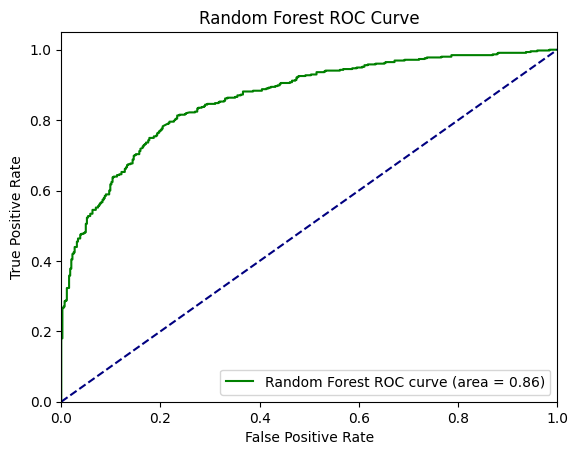

In [13]:
# Random Forest Model AUC
train_sentiment, test_sentiment, train_score, test_score = train_test_split(X, y, test_size=0.3)
rf_model = RandomForestClassifier(max_depth=best_rf.max_depth, n_estimators=best_rf.n_estimators)
vectorizer = CountVectorizer()

vector_sentiment_train = vectorizer.fit_transform(train_sentiment)
vector_sentiment_test = vectorizer.transform(test_sentiment)
rf_model.fit(vector_sentiment_train, train_score)
# Obtain predicted probabilities
predict_score_prob = rf_model.predict_proba(vector_sentiment_test)[:,1]

# Compute ROC curve and ROC area
fpr_rf, tpr_rf, _ = roc_curve(test_score, predict_score_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)
# Plot Random Forest ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color="green", label=f"Random Forest ROC curve (area = {round(roc_auc_rf, 2)})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()


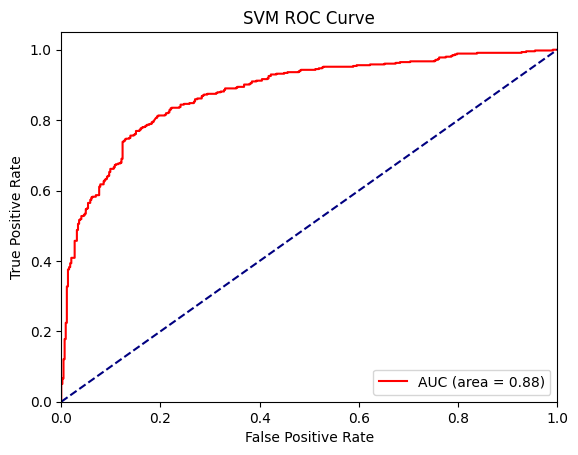

In [14]:
svm_model = SVC(C=best_svm.C, gamma=best_svm.gamma, kernel=best_svm.kernel, probability=True)
vectorizer = CountVectorizer()

vector_sentiment_train = vectorizer.fit_transform(train_sentiment)
vector_sentiment_test = vectorizer.transform(test_sentiment)
svm_model.fit(vector_sentiment_train, train_score)
# Obtain predicted probabilities
predicted_svm_score = svm_model.predict_proba(vector_sentiment_test)[:,1]
# Compute ROC curve and ROC area
fpr_svm, tpr_svm, _ = roc_curve(test_score, predicted_svm_score)
roc_auc_svm = auc(fpr_svm, tpr_svm)
# Plot SVM ROC curve
plt.figure()
plt.plot(fpr_svm, tpr_svm, color="red", label=f"AUC (area = {round(roc_auc_svm,2)})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.legend(loc="lower right")
plt.show()


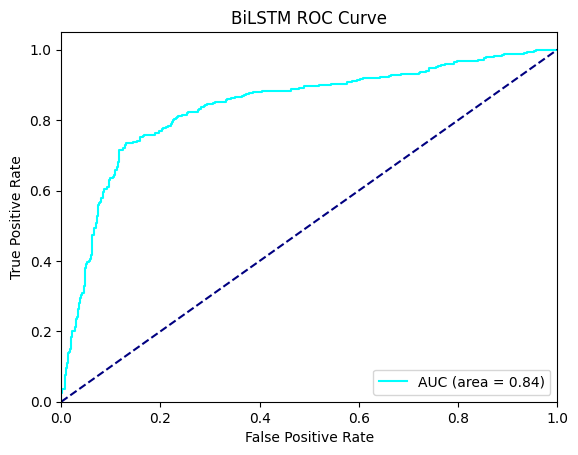

In [15]:
VOCAB_SIZE = 3000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(np.array(train_sentiment))
biLSTM_model = tf.keras.Sequential([encoder,
                           tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                                     output_dim=64,
        # Use masking to handle the variable sequence lengths
                                                     mask_zero=True),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                           tf.keras.layers.Dense(64, activation='relu'),
                           tf.keras.layers.Dense(1)])

biLSTM_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
	# fit model
biLSTM_model.fit(np.array(train_sentiment), np.array(train_score), epochs=10, batch_size=64, verbose=0)

predicted_score_biLSTM = biLSTM_model.predict(test_sentiment, verbose=0)

fpr_biLSTM, tpr_biLSTM, _ = roc_curve(test_score, predicted_score_biLSTM)
roc_auc_biLSTM = auc(fpr_biLSTM, tpr_biLSTM)

plt.figure()
plt.plot(fpr_biLSTM, tpr_biLSTM, color="aqua", label=f"AUC (area = {round(roc_auc_biLSTM,2)})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BiLSTM ROC Curve")
plt.legend(loc="lower right")
plt.show()